In [46]:
import h5py
import tangos as db
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# How to read in file that contains data on every star that is in Tempest's stellar halo at z=0
f = h5py.File('/Users/bnguyen/Downloads/Tempest_RD0042_allhalostardata.h5','r')
pids = f['particle_IDs'][:] # particle index of star - constant across simulation (int)
ptind = f['timestep_location'][:] # index of timestep at which star formed (int; 0->DD0044)
hids = f['host_IDs'].asstr()[:] # unique ID of halo in which star forms (string, constant across simulation)
pp = f['particle_positions'][:] # location at which star forms ([x,y,z], float, Mpc)
ct = f['particle_creation_times'][:] # time at which star was formed (float, Gyr)
ph = f['particle_hosts'][:] # halo number of halo in which star forms (int, holds only for timestep)
f.close()
# Note: some star particles form before our first saved timestep or in halos that our halo finder has lost track of.
# The vast majority can still be reliably assigned to a halo via other methods and therefore have a 'host_IDs' value.
# However, they may have 0s or -1s for 'timestep_location' and/or 'particle_hosts'.
# The 'host_IDs' value is the most important means of grouping halo stars. Star particles that formed in the same halo
# at different timesteps will have different 'timestep_locations' values and possibly different 'particle_hosts' values,
# but they will have the same 'host_IDs' value. The 'host_IDs' value can be understood as follows:
#   The number before the underscore is the timestep at which the star-forming halo was last distinguished by the halo
#   finder as an independent halo, either before it merged with another, more massive halo or before it lost too many
#   particles to be tracked.
#   The number after the underscore is the halo number of the halo at this timestep.
#   So, for example, a 'host_IDs' value of '1878_101' means that this star formed in a halo that is last 
#   distinguished at timestep DD1878 and has halo_number = 101 at this timestep. A star with 'host_IDs'='2427_1'
#   formed inside of Tempest itself.

In [3]:
allhosts = np.unique(hids)
allhosts = allhosts[allhosts != '']
allhosts = allhosts[allhosts != '2427_1'] # This excludes Tempest itself, whose host ID is '2427_1'

print ('Tempest has '+str(len(allhosts))+' independent halos that contribute to its stellar halo.')
print ('These are:',allhosts[:])

Tempest has 49 independent halos that contribute to its stellar halo.
These are: ['0113_6' '0142_77' '0152_77' '0153_75' '0154_40' '0190_55' '0199_30'
 '0200_22' '0208_111' '0216_75' '0299_171' '0310_12' '0312_251' '0323_33'
 '0324_14' '0326_1' '0326_2' '0373_57' '0377_65' '0386_39' '0395_35'
 '0397_46' '0398_24' '0400_62' '0409_28' '0410_28' '0416_51' '0419_83'
 '0427_16' '0448_94' '0468_7' '0520_296' '0570_6' '0627_4' '0641_51'
 '0745_57' '0786_3' '0840_159' '0946_68' '0994_85' '1057_92' '1092_39'
 '1233_7' '1487_28' '1645_5' '1649_6' '1779_14' '1878_101' '2427_51']


In [4]:
time_index = np.zeros(len(allhosts))
halo_number = np.zeros(len(allhosts))

i = 0
for s in allhosts:
    string = s.split('_')
    time_index[i] = int(string[0])
    halo_number[i] = string[1]
    i += 1
    
# we also have to subtract by 44 because that's the first timestep
time_index = time_index.astype(int) - 44 

In [5]:
print(time_index)
print(type(time_index[2]))

[  69   98  108  109  110  146  155  156  164  172  255  266  268  279
  280  282  282  329  333  342  351  353  354  356  365  366  372  375
  383  404  424  476  526  583  597  701  742  796  902  950 1013 1048
 1189 1443 1601 1605 1735 1834 2383]
<class 'numpy.int64'>


In [21]:
print(sim[2383][51])

<Halo 'Tempest.9f11c.all.DD/DD2427/DD2427/halo_51' | NDM=182 Nstar=0 Ngas=0>


In [6]:
db.all_simulations()

[<Simulation("Tempest.9f11c.all.DD")>]

In [7]:
sim = db.get_simulation('Tempest.9f11c.all.DD')

In [8]:
'''This finds the time at which each halo starts contributing (a.k.a. getting stripped) to Tempest.'''

halo_time = np.zeros(len(allhosts))
i = 0
for index in time_index:
    halo_time[i] = sim[int(index)].time_gyr
    i += 1
    
print(halo_time)

[ 1.31938417  1.47538672  1.52918071  1.53456011  1.53993951  1.73359786
  1.78201244  1.78739184  1.83042703  1.87346222  2.3199523   2.37912568
  2.38988448  2.44905786  2.45443726  2.46519606  2.46519606  2.71802779
  2.73954539  2.78795997  2.83637456  2.84713336  2.85251276  2.86327155
  2.91168614  2.91706554  2.94934193  2.9654798   3.00851532  3.12148269
  3.22907066  3.50879938  3.77776931  4.08439503  4.15970661  4.71916406
  4.9397194   5.23020692  5.80042317  6.0532549   6.39215701  6.58043596
  7.33893116  8.70529839  9.55524337  9.57676096 10.27608277 10.80864323
 13.75931383]


In [9]:
print(time_index[40])
print(halo_number[40])
the_host = sim[1013][92].calculate('Hosts()')
the_host_idx = the_host[0].halo_number
print(the_host_idx)

1013
92.0
1


In [48]:
i = 0

all_sat_t = []
all_sat_r = []
all_sat_ratio = []
all_sat_mvir_ratio = []
all_host_rvir = []

while i < np.size(halo_number):
    sat_idx = int(halo_number[i])
    time_idx = int(time_index[i])
            
    if isinstance(sim[time_idx][sat_idx], type(None)) is False:
        # this uses pre-coded tangos stuff to get M_vir and distance measurements at all available redshifts
        host_rvir, host_mvir, host_x, host_y, host_z, host_t = \
                        sim[time_idx][1].calculate_for_progenitors('Rvir', 'Mvir', 'X', 'Y', 'Z', 't()')
        sat_mvir, sat_x, sat_y, sat_z, sat_t = \
                        sim[time_idx][sat_idx].calculate_for_progenitors('Mvir', 'X', 'Y', 'Z', 't()')

        # now, we have to correct for the distance of the satellite halos from the host halo, which itself
        # is also moving. to do this, we need to subtract the position of the satellite by the position of
        # the host. 
        # because the host halo and satellite halos might not be observed at the exact same amount of redshifts,
        # we first need to exclude the non-overlapping redshifts so that it's easier to subtract

        ### this checks for non-overlapping redshifts between host and satellite. 
        ### if non-overlapping, then array element set to 0
        for j in range(np.size(host_t)):
            if host_t[j] not in sat_t: 
                host_t[j] = 0.
                host_x[j] = 0.
                host_y[j] = 0.
                host_z[j] = 0.
                host_rvir[j] = 0.
                host_mvir[j] = 0.

        ### this checks for non-overlapping redshifts between satellite and host. 
        ### if non-overlapping, then array element set to 0
        for k in range(np.size(sat_t)):
            if sat_t[k] not in host_t:
                sat_t[k] = 0.
                sat_x[k] = 0.
                sat_y[k] = 0.
                sat_z[k] = 0.
                sat_mvir[k] = 0.

        ### this removes all the zeros
        host_t = host_t[host_t != 0.]
        host_x = host_x[host_x != 0.]
        host_y = host_y[host_y != 0.]
        host_z = host_z[host_z != 0.]
        host_rvir = host_rvir[host_rvir != 0.]
        host_mvir = host_mvir[host_mvir != 0.]
        sat_t = sat_t[sat_t != 0.]
        sat_x = sat_x[sat_x != 0.]
        sat_y = sat_y[sat_y != 0.]
        sat_z = sat_z[sat_z != 0.]
        sat_mvir = sat_mvir[sat_mvir != 0.]

        # here comes the actual subtracting correction
        sat_x = sat_x - host_x
        sat_y = sat_y - host_y
        sat_z = sat_z - host_z

        # finally, we get the 3D distance and scale it by the virial radius of the host halo (Tempest)
        sat_r = np.sqrt(sat_x**2 + sat_y**2 + sat_z**2)

        # this plots distance vs. time for each halo with regard to their host halo
        mass_ratio = sat_mvir / max(sat_mvir)
        
        all_sat_t.append(sat_t)
        all_sat_r.append(sat_r)
        all_sat_ratio.append(sat_r * 1000 / host_rvir)
        all_sat_mvir_ratio.append(mass_ratio)
        all_host_rvir.append(host_rvir)
        
        print(sat_idx, time_idx)
            
    i += 1
    
all_sat_t = np.array(all_sat_t)
all_sat_r = np.array(all_sat_r)
all_sat_ratio = np.array(all_sat_ratio)

print('success!')

6 69
77 98
77 108
75 109
40 110
55 146
30 155
22 156
111 164
75 172
171 255
12 266
251 268
33 279
14 280
1 282
2 282
57 329
65 333
39 342
35 351
46 353
24 354
62 356
28 365
28 366
51 372
83 375
16 383
94 404
7 424
296 476
6 526
4 583
51 597
57 701
3 742
159 796
68 902
85 950
92 1013
39 1048
7 1189
28 1443
5 1601
6 1605
14 1735
101 1834
51 2383
success!


/var/folders/h4/tgpyd_z951x_9bzqftct7zxc00057b/T/ipykernel_17931/1560637409.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_sat_t = np.array(all_sat_t)
/var/folders/h4/tgpyd_z951x_9bzqftct7zxc00057b/T/ipykernel_17931/1560637409.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_sat_r = np.array(all_sat_r)
/var/folders/h4/tgpyd_z951x_9bzqftct7zxc00057b/T/ipykernel_17931/1560637409.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different len

In [51]:
# this is just to generate the same colors for both plots

r_array = []
b_array = []
g_array = []

for i in range(np.size(all_sat_t)):
    r = random.random()
    b = random.random()
    g = random.random()
    r_array.append(r)
    b_array.append(b)
    g_array.append(g)
    
r_array = np.array(r_array)
b_array = np.array(b_array)
g_array = np.array(g_array)

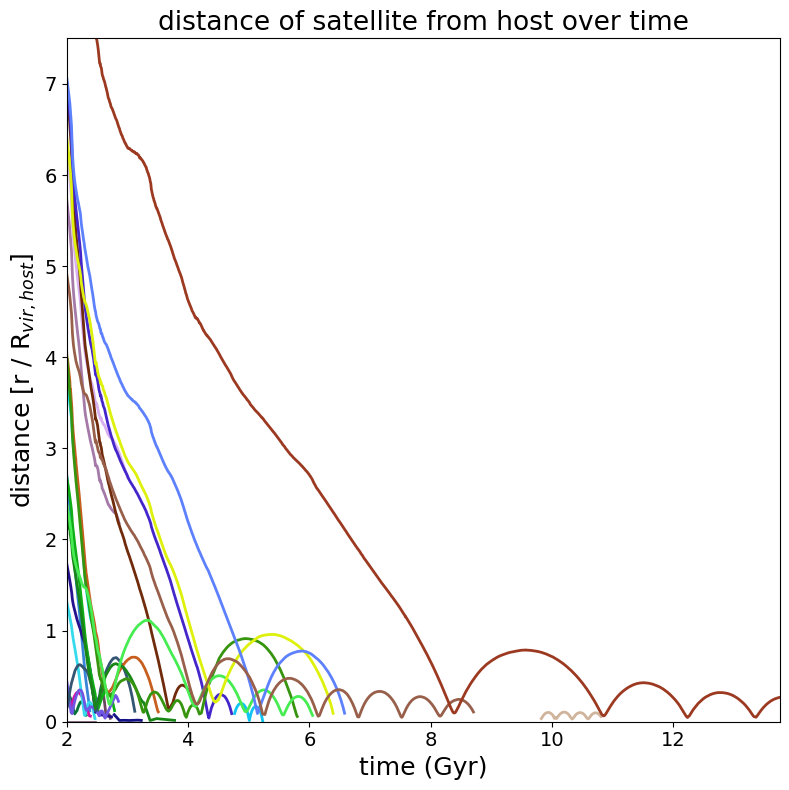

In [52]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    plt.plot(all_sat_t[i], all_sat_ratio[i], linewidth=2, c=(r_array[i], b_array[i], g_array[i]))
    
#plt.legend(loc='upper left', bbox_to_anchor=[1.01, 1.01])
plt.title('distance of satellite from host over time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
plt.ylim(0, 7.5)
plt.xlim(2, max(sat_t))
plt.tight_layout()
plt.style.use('default')
plt.savefig('stripped_sat_distance_over_time.png')

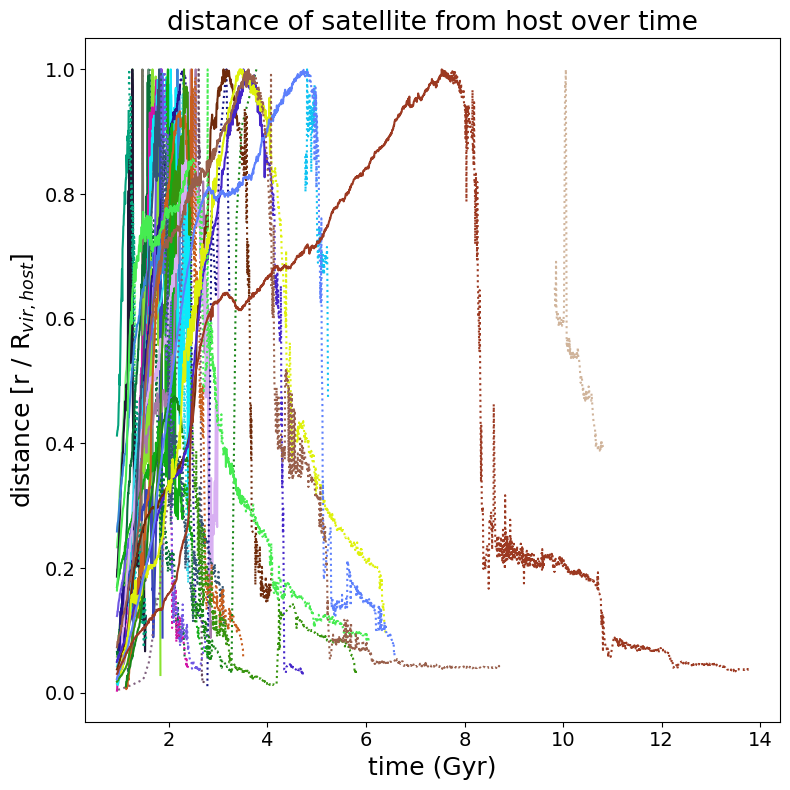

In [55]:
fig, ax = plt.subplots(figsize=(8,8))

for i in range(np.size(all_sat_t)):
    radius_ratio = all_sat_r[i] * 1000 / all_host_rvir[i]
    in_rvir = radius_ratio <= 1
    out_rvir = radius_ratio > 1
    plt.plot(all_sat_t[i], np.ma.masked_where(in_rvir, all_sat_mvir_ratio[i]), linestyle='-', \
             c=(r_array[i], b_array[i], g_array[i]))
    plt.plot(all_sat_t[i], np.ma.masked_where(out_rvir, all_sat_mvir_ratio[i]), linestyle=':', \
             c=(r_array[i], b_array[i], g_array[i]))
    
plt.title('distance of satellite from host over time', fontsize=19)
plt.xlabel('time (Gyr)', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('distance [r / R$_{vir,host}$]', fontsize=18)
plt.yticks(fontsize=14)
#plt.ylim(0, 1.25)
#plt.xlim(2, max(sat_t))
plt.tight_layout()
plt.style.use('default')
plt.savefig('stripped_sat_mvir_over_time.png')